# Facial Landmarks
Project based on [this tutorial](http://www.pyimagesearch.com/2017/04/03/facial-landmarks-dlib-opencv-python/)

OpenCV and dlib need to be installed. For anaconda:

`conda install -c https://conda.anaconda.org/menpo opencv3` [.](https://stackoverflow.com/a/35056306/1804027)

`conda install -c menpo dlib` [.](https://github.com/davisking/dlib/issues/218#issuecomment-279689660)

Name of anaconda environment: `face_detection`

In [1]:
%matplotlib inline

# import the necessary packages
from imutils import face_utils
import numpy as np
import argparse
import imutils
import dlib
import cv2
import matplotlib.pyplot as plt
import copy

# initialize dlib's face detector (HOG-based) and then create
# the facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# load the input image, resize it, and convert it to grayscale
image = cv2.imread("jakisfacet.jpg")
image = imutils.resize(image, width=500)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
 
# detect faces in the grayscale image
rects = detector(gray, 1)
print("Number of faces detected: {}".format(len(rects)))

Number of faces detected: 1


In [2]:
# Code found here https://github.com/kendricktan/iffse/blob/master/iffse/utils/cv/faces.py#L80

FACIAL_LANDMARKS_TEMPLATE = np.float32([
    (0.0792396913815, 0.339223741112), (0.0829219487236, 0.456955367943),
    (0.0967927109165, 0.575648016728), (0.122141515615, 0.691921601066),
    (0.168687863544, 0.800341263616), (0.239789390707, 0.895732504778),
    (0.325662452515, 0.977068762493), (0.422318282013, 1.04329000149),
    (0.531777802068, 1.06080371126), (0.641296298053, 1.03981924107),
    (0.738105872266, 0.972268833998), (0.824444363295, 0.889624082279),
    (0.894792677532, 0.792494155836), (0.939395486253, 0.681546643421),
    (0.96111933829, 0.562238253072), (0.970579841181, 0.441758925744),
    (0.971193274221, 0.322118743967), (0.163846223133, 0.249151738053),
    (0.21780354657, 0.204255863861), (0.291299351124, 0.192367318323),
    (0.367460241458, 0.203582210627), (0.4392945113, 0.233135599851),
    (0.586445962425, 0.228141644834), (0.660152671635, 0.195923841854),
    (0.737466449096, 0.182360984545), (0.813236546239, 0.192828009114),
    (0.8707571886, 0.235293377042), (0.51534533827, 0.31863546193),
    (0.516221448289, 0.396200446263), (0.517118861835, 0.473797687758),
    (0.51816430343, 0.553157797772), (0.433701156035, 0.604054457668),
    (0.475501237769, 0.62076344024), (0.520712933176, 0.634268222208),
    (0.565874114041, 0.618796581487), (0.607054002672, 0.60157671656),
    (0.252418718401, 0.331052263829), (0.298663015648, 0.302646354002),
    (0.355749724218, 0.303020650651), (0.403718978315, 0.33867711083),
    (0.352507175597, 0.349987615384), (0.296791759886, 0.350478978225),
    (0.631326076346, 0.334136672344), (0.679073381078, 0.29645404267),
    (0.73597236153, 0.294721285802), (0.782865376271, 0.321305281656),
    (0.740312274764, 0.341849376713), (0.68499850091, 0.343734332172),
    (0.353167761422, 0.746189164237), (0.414587777921, 0.719053835073),
    (0.477677654595, 0.706835892494), (0.522732900812, 0.717092275768),
    (0.569832064287, 0.705414478982), (0.635195811927, 0.71565572516),
    (0.69951672331, 0.739419187253), (0.639447159575, 0.805236879972),
    (0.576410514055, 0.835436670169), (0.525398405766, 0.841706377792),
    (0.47641545769, 0.837505914975), (0.41379548902, 0.810045601727),
    (0.380084785646, 0.749979603086), (0.477955996282, 0.74513234612),
    (0.523389793327, 0.748924302636), (0.571057789237, 0.74332894691),
    (0.672409137852, 0.744177032192), (0.572539621444, 0.776609286626),
    (0.5240106503, 0.783370783245), (0.477561227414, 0.778476346951)])

FL_MIN = np.min(FACIAL_LANDMARKS_TEMPLATE, axis=0)
FL_MAX = np.max(FACIAL_LANDMARKS_TEMPLATE, axis=0)
SCALED_LANDMARKS = (FACIAL_LANDMARKS_TEMPLATE - FL_MIN) / (FL_MAX - FL_MIN)

#: Landmark indices.
INNER_EYES_AND_BOTTOM_LIP = [39, 42, 57]
OUTER_EYES_AND_NOSE = [36, 45, 33]
TEST_TEST_TEST = [48, 62, 54]

def align_face_to_template(img, facial_landmarks, output_dim, landmarkIndices=INNER_EYES_AND_BOTTOM_LIP):
    """
    Aligns image by warping it to fit the landmarks on
    the image (src) to the landmarks on the template (dst)
    Args:
        img: src image to be aligned
        facial_landmarks: list of 68 landmarks (obtained from dlib)
        output_dim: image output dimension
    """
    np_landmarks = np.float32(facial_landmarks)
    np_landmarks_idx = np.array(landmarkIndices)

    H = cv2.getAffineTransform(np_landmarks[np_landmarks_idx],
                               output_dim * SCALED_LANDMARKS[np_landmarks_idx])
    warped = cv2.warpAffine(img, H, (output_dim, output_dim))

    return warped

In [3]:
transformed_imgs = [];
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# duplicate image, so that editing `imageWithNotes` won't impact `image`
imageWithNotes = copy.deepcopy(image)

# loop over the face detections
for (i, rect) in enumerate(rects):
    print("Detection {}: Left: {} Top: {} Right: {} Bottom: {}".format(
            i, rect.left(), rect.top(), rect.right(), rect.bottom()))
    # determine the facial landmarks for the face region, then
    # convert the facial landmark (x, y)-coordinates to a NumPy
    # array
    shape = predictor(gray, rect)
    shape = face_utils.shape_to_np(shape)
    
    transformed_imgs.append(align_face_to_template(image, shape, 256))

    # convert dlib's rectangle to a OpenCV-style bounding box
    # [i.e., (x, y, w, h)], then draw the face bounding box
    (x, y, w, h) = face_utils.rect_to_bb(rect)
    cv2.rectangle(imageWithNotes, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # show the face number
    cv2.putText(imageWithNotes, "Face #{}".format(i + 1), (x - 10, y - 10),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # loop over the (x, y)-coordinates for the facial landmarks
    # and draw them on the image
    for (x, y) in shape:
        cv2.circle(imageWithNotes, (x, y), 1, (0, 0, 255), -1)

Detection 0: Left: 221 Top: 78 Right: 329 Bottom: 186


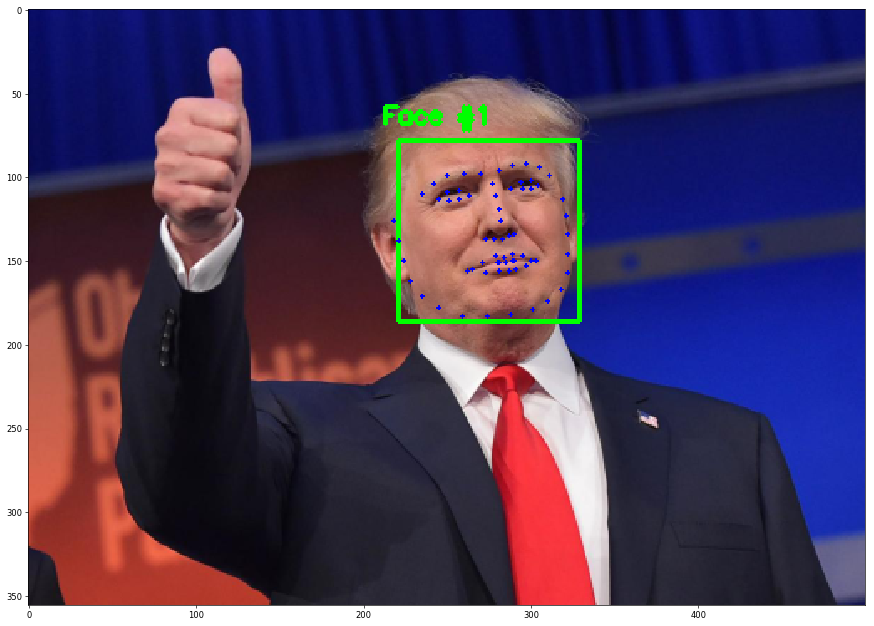

In [4]:
 # show the output image with the face detections + facial landmarks
fig=plt.figure(figsize=(18, 16), dpi= 60, facecolor='w', edgecolor='k')
plt.imshow(imageWithNotes)

0


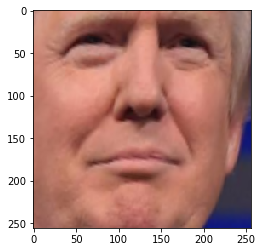

In [5]:

for x, ti in enumerate(transformed_imgs):
    print(x)
    plt.imshow(ti)
    plt.show()

In [6]:
class FaceData():
    def __init__(self, landmarks):
        self.eyeL = landmarks[36]
        self.eyeR = landmarks[45]
        self.noseTop = landmarks[27]
        self.noseBottom = landmarks[30]
        self.mouthCenter = landmarks[51]

def ReturnAllTransformedFaces(image):
    """
    Everything that had been done above, in one function
    """
    rects = detector(image)
    transformed_imgs = []
    landmarks = []
    # loop over the face detections
    for (i, rect) in enumerate(rects):
        # determine the facial landmarks for the face region, then
        # convert the facial landmark (x, y)-coordinates to a NumPy
        # array
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)
        landmarks.append(FaceData(shape))
        """
        aligned_face = align_face_to_template(image, shape, 256)
        transformed_imgs.append(aligned_face)
        
        new_img_height, new_img_width, new_img_channels = aligned_face.shape
        print(aligned_face.shape)
        
        new_rect = dlib.rectangle(0, 0, 0 + new_img_width, 0 + new_img_height)
        
        new_shape = predictor(aligned_face, new_rect)
        new_shape = face_utils.shape_to_np(new_shape)
        landmarks.append(new_shape)
        """
    
    return landmarks
     
landmarks = ReturnAllTransformedFaces(image)
"""
for q, ti in enumerate(transformed_imgs):
    print(q)
    for (x, y) in landmarks[q]:
        cv2.circle(ti, (x, y), 1, (0, 0, 255), -1)
    plt.imshow(ti)
    plt.show()
"""
print(landmarks[0].eyeL)
print(landmarks[0].eyeR)
print(landmarks[0].noseTop)
print(landmarks[0].noseBottom)

[246 113]
[304 106]
[277 104]
[282 126]


In [7]:
landmarks
